In [59]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Final Sizing 3.0
# Mass Parameters
EW = 104994.6462
MTOW = 209919.0362
Fuel = 28324.39
EW_CG = 1007.770505
MZF = MTOW - Fuel

# Retardant Tank Positions
Forward_Tank_pos = 923.762434
Aft_Tank_pos = 1091.76
# Forward_Tank_pos += 5
# Aft_Tank_pos += 5

# Fuel Tank Positions
Center_Tank_pos = 1022 
Wing_Tank_pos = 1026.1 #assume same for both wing tanks
Reserve_Tank_pos = 1028.9

# Fuel Tank Sizes (lbs)
Center_Tank_size = 12178.65
Wing_Tank_size = 10695.74
Reserve_Tank_size = 4435.31

# Aero
MAC = 193.6552969
LEMAC = 946.2232478

# Gear Position
NG_pos = 684.57
MG_pos = 1055.07

# Gear Weight Limits
NG_Weight_Limit = 32200

#Limits
Forward_Limit = 20.77
Aft_Limit = 43.69

In [60]:
def mtp(percent):
    return (percent/100)*MAC+LEMAC

def ptm(pos):
    return ((pos-LEMAC)/MAC)*100

def FuelCG(Fuel_Weight):
    #params: Fuel_Weight = Weight of Fuel in lbs
    #return: Overall cg of the fuel tanks in inches w.r.t. reference coordinate system
    
    if Fuel_Weight == 0:
        return 0
    
    Total_Fuel_Weight = copy.copy(Fuel_Weight)
    Fuel_Moment = 0
    
    if Fuel_Weight > Center_Tank_size:
        Fuel_Moment += Center_Tank_size * Center_Tank_pos
        Fuel_Weight -= Center_Tank_size
    else:
        Fuel_Moment = Fuel_Weight * Center_Tank_pos
        return Fuel_Moment/Total_Fuel_Weight
    
    if Fuel_Weight > (Wing_Tank_size*2):
        Fuel_Moment += (Wing_Tank_size*2) * Wing_Tank_pos
        Fuel_Weight -= (Wing_Tank_size*2)
    else:
        Fuel_Moment += Fuel_Weight * Wing_Tank_pos
        return Fuel_Moment/Total_Fuel_Weight
    
    if Fuel_Weight > (Reserve_Tank_size*2):
        Fuel_Moment += (Reserve_Tank_size*2) * Reserve_Tank_pos
        Fuel_Weight -= (Reserve_Tank_size*2)
        print('more fuel than capacity')
    else:
        Fuel_Moment += Fuel_Weight * Reserve_Tank_pos
        
    return Fuel_Moment/Total_Fuel_Weight

def RetardantCG(Forward_Tank_Vol, Aft_Tank_Vol):
    #params: 
    #return: 
    #includes empty tanks
    
    Retardant_Moment = 0
    Retardant_Moment += (Forward_Tank_Vol*9 + 2300)*Forward_Tank_pos + (Aft_Tank_Vol*9 + 2300)*Aft_Tank_pos

    return Retardant_Moment/(Forward_Tank_Vol*9 + 2300 + Aft_Tank_Vol*9 + 2300)
    
    
    

In [61]:
# Onion Rings
# Onion Rings are only after empty tanks are in place
def OnionRing(Fuel_Weight, Forward_Tank_Vol, Aft_Tank_Vol, string = None):
    #params:
    #return:
    
    Total_Weight = EW + Fuel_Weight + 2*2300 + (Forward_Tank_Vol + Aft_Tank_Vol)*9
    newCG = (EW*EW_CG + Fuel_Weight*FuelCG(Fuel_Weight) + (2*2300 + (Forward_Tank_Vol + Aft_Tank_Vol) * 9)*RetardantCG(Forward_Tank_Vol, Aft_Tank_Vol)) / Total_Weight
    
    Forward_Shift_Moment = 0
    Aft_Shift_Moment = 0
    
    if string == 'pos':
        #CG with +13 degree pitch
        if Forward_Tank_Vol != 0:
            Forward_Shift_Moment = 214272
        if Aft_Tank_Vol != 0:
            Aft_Shift_Moment = 214272
    
    if string == 'neg':
        #CG with -13 degree pitch
        if Forward_Tank_Vol != 0:
            Forward_Shift_Moment = -214272
        if Aft_Tank_Vol != 0:
            Aft_Shift_Moment = -214272
        
    shiftCG = newCG + (Forward_Shift_Moment + Aft_Shift_Moment)/Total_Weight
    
    return ptm(newCG), Total_Weight, ptm(shiftCG)

def EmptyTanks(Fuel, Forwardpos, Aftpos):
    Forward_Weight = 2300
    Aft_Weight = 2300
    if Forwardpos == 0:
        Forward_Weight = 0
    if Aftpos == 0:
        Aft_Weight = 0
    Total_Weight = Fuel + EW + Forward_Weight + Aft_Weight
    EmptyTanksCG = (EW*EW_CG + Fuel*FuelCG(Fuel) + Forward_Weight*Forwardpos + Aft_Weight*Aftpos)/Total_Weight
    
    return ptm(EmptyTanksCG), Total_Weight

             
             

In [62]:
#Nose Landing Gear Steering Minimum Limit
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

CGin,GW,MG_Weight,NG_Weight = sym.symbols('CGin,GW,MG_Weight,NG_Weight')
# eq1 = sym.Eq(MG_Weight, 0.95*213000)
eq2 = sym.Eq(0.08*10*(CGin - NG_pos), 0.92*10*(MG_pos - CGin))
result = sym.solve([eq2],(CGin))
print(result[CGin])
Steering_Limit = result[CGin]

1025.43000000000


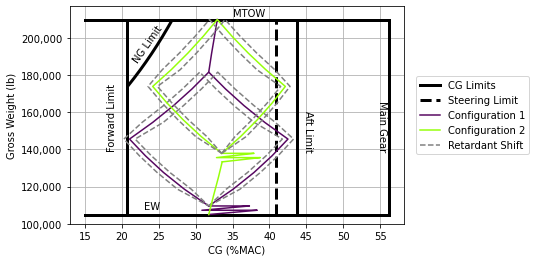

In [63]:
############LIMITS##########

xleft = 15
xright = 56
#MTOW
x = np.linspace(xleft, xright, 100)
y = MTOW + 0*x
plt.plot(x,y, linestyle='solid', linewidth = 3, color = 'black', label='CG Limits')

# #MZF
# x = np.linspace(xleft, xright, 100)
# y = MZF + 0*x
# plt.plot(x,y, linestyle = 'dashed')

#Empty_Weight
x = np.linspace(xleft, xright, 100)
y = EW + 0*x
plt.plot(x,y, linestyle='solid', linewidth = 3, color = 'black')

#Nose Landing Gear Max Weight Limit
x = np.linspace(Forward_Limit+0.1, 26.7, 1000)
inCG = (x/100)*MAC + LEMAC
y = NG_Weight_Limit*((inCG-NG_pos)/(MG_pos-inCG)) + NG_Weight_Limit
plt.plot(x,y, linestyle='solid', linewidth = 3, color = 'black')

#Nose Landing Gear Steering Limit Fraction
x = np.linspace(EW, MTOW, 100)
NG_Steering = ptm(Steering_Limit) + 0*x
plt.plot(NG_Steering,x, linestyle='dashed', linewidth = 3, color = 'black', label='Steering Limit')

#Main Landing Gear Position
x = np.linspace(EW, MTOW, 100)
MainLandingGear = ptm(MG_pos) + 0*x
plt.plot(MainLandingGear, x, linestyle='solid', linewidth = 3, color = 'black')

#Forward Limit
x = np.linspace(EW, MTOW, 100)
Forward_Lim = Forward_Limit + 0*x
plt.plot(Forward_Lim,x, linestyle='solid', linewidth = 3, color = 'black')

#Aft Limit
x = np.linspace(EW, MTOW, 100)
Aft_Lim = Aft_Limit + 0*x
plt.plot(Aft_Lim,x, linestyle='solid', linewidth = 3, color = 'black')

####################################################CG Travel#########################################################

#########################################Empty Tanks->Retardant->Fuel#################################################
Config_1_Colour = (87/255, 8/255, 97/255)
Config_2_Colour = (150/255, 255/255, 10/255)

# #Dark Blue vs Light Blue
# Config_1_Colour = (0/255,114/255, 178/255)
# Config_2_Colour = (86/255, 180/255, 233/255)

#Loading and Unloading Empty Retardant Tanks
#assume aircraft starts at empty weight
#start with no tanks then forward tank brought to position then aft tank brought to position
distfor = [0, 1600, 1400, 1200, Forward_Tank_pos]
distaft = [0, 1600, 1400, 1200, Aft_Tank_pos]
x = []
y = []
for i in distfor:
    x.append(EmptyTanks(0, i, 0)[0])
    y.append(EmptyTanks(0, i, 0)[1])
for j in distaft:
    x.append(EmptyTanks(0, Forward_Tank_pos, j)[0])
    y.append(EmptyTanks(0, Forward_Tank_pos, j)[1])
plt.plot(x,y, color=Config_1_Colour)


#Filling Retardant Tanks, Aft First then Forward
#Assume empty tanks have been placed and zero fuel
x = [OnionRing(0, 0, 0)[0], OnionRing(0, 0, 1000)[0], OnionRing(0, 0, 2000)[0], OnionRing(0, 0, 3000)[0], OnionRing(0, 0, 4000)[0], OnionRing(0, 1000, 4000)[0], OnionRing(0, 2000, 4000)[0], OnionRing(0, 3000, 4000)[0], OnionRing(0, 4000, 4000)[0], OnionRing(0, 4000, 3000)[0], OnionRing(0, 4000, 2000)[0], OnionRing(0, 4000, 1000)[0], OnionRing(0, 4000, 0)[0], OnionRing(0, 3000, 0)[0], OnionRing(0, 2000, 0)[0], OnionRing(0, 1000, 0)[0], OnionRing(0, 0, 0)[0]]
xshiftpos = [OnionRing(0, 0, 0, 'pos')[2], OnionRing(0, 0, 1000, 'pos')[2], OnionRing(0, 0, 2000, 'pos')[2], OnionRing(0, 0, 3000, 'pos')[2], OnionRing(0, 0, 4000, 'pos')[2], OnionRing(0, 1000, 4000, 'pos')[2], OnionRing(0, 2000, 4000, 'pos')[2], OnionRing(0, 3000, 4000, 'pos')[2], OnionRing(0, 4000, 4000, 'pos')[2], OnionRing(0, 4000, 3000, 'pos')[2], OnionRing(0, 4000, 2000, 'pos')[2], OnionRing(0, 4000, 1000, 'pos')[2], OnionRing(0, 4000, 0, 'pos')[2], OnionRing(0, 3000, 0, 'pos')[2], OnionRing(0, 2000, 0, 'pos')[2], OnionRing(0, 1000, 0, 'pos')[2], OnionRing(0, 0, 0, 'pos')[2]]
xshiftneg = [OnionRing(0, 0, 0, 'neg')[2], OnionRing(0, 0, 1000, 'neg')[2], OnionRing(0, 0, 2000, 'neg')[2], OnionRing(0, 0, 3000, 'neg')[2], OnionRing(0, 0, 4000, 'neg')[2], OnionRing(0, 1000, 4000, 'neg')[2], OnionRing(0, 2000, 4000, 'neg')[2], OnionRing(0, 3000, 4000, 'neg')[2], OnionRing(0, 4000, 4000, 'neg')[2], OnionRing(0, 4000, 3000, 'neg')[2], OnionRing(0, 4000, 2000, 'neg')[2], OnionRing(0, 4000, 1000, 'neg')[2], OnionRing(0, 4000, 0, 'neg')[2], OnionRing(0, 3000, 0, 'neg')[2], OnionRing(0, 2000, 0, 'neg')[2], OnionRing(0, 1000, 0, 'neg')[2], OnionRing(0, 0, 0, 'neg')[2]]
y = [OnionRing(0, 0, 0)[1], OnionRing(0, 0, 1000)[1], OnionRing(0, 0, 2000)[1], OnionRing(0, 0, 3000)[1], OnionRing(0, 0, 4000)[1], OnionRing(0, 1000, 4000)[1], OnionRing(0, 2000, 4000)[1], OnionRing(0, 3000, 4000)[1], OnionRing(0, 4000, 4000)[1], OnionRing(0, 4000, 3000)[1], OnionRing(0, 4000, 2000)[1], OnionRing(0, 4000, 1000)[1], OnionRing(0, 4000, 0)[1], OnionRing(0, 3000, 0)[1], OnionRing(0, 2000, 0)[1], OnionRing(0, 1000, 0)[1], OnionRing(0, 0, 0)[1]]
plt.plot(x, y, color=Config_1_Colour)
plt.plot(xshiftpos, y, linestyle = 'dashed', color='gray' )
plt.plot(xshiftneg, y, linestyle = 'dashed', color='gray')

#adding fuel after all retardant
x = []
y = []
fuellist = [0, 10000, 20000, Fuel]
for i in fuellist:
    x.append(OnionRing(i, 4000, 4000)[0])
    y.append(OnionRing(i, 4000, 4000)[1])
plt.plot(x, y, color=Config_1_Colour, label='Configuration 1')

#######################################Fuel->Empty Tanks->Retardant#################################################

# #Fuel Loading
# #starts with empty weight
x=[]
y=[]
def OverallFuelCG(Fuel):
    #Loading fuel from empty weight
    Total_Weight = EW + Fuel
    OverallFuelCG = (Fuel*FuelCG(Fuel) + EW*EW_CG) / Total_Weight
    return ptm(OverallFuelCG), Total_Weight
fuellist = [0, 10000, 20000, Fuel]
for i in fuellist:
    x.append(OverallFuelCG(i)[0])
    y.append(OverallFuelCG(i)[1])
plt.plot(x, y, color=Config_2_Colour)

# #Loading and Unloading Empty Retardant Tanks
# #assume fuel has been filled already
# #start with no tanks then forward tank brought to position then aft tank brought to position
distfor = [0, 1600, 1400, 1200, Forward_Tank_pos]
distaft = [0, 1600, 1400, 1200, Aft_Tank_pos]
x = []
y = []
for i in distfor:
    x.append(EmptyTanks(Fuel, i, 0)[0])
    y.append(EmptyTanks(Fuel, i, 0)[1])
for j in distaft:
    x.append(EmptyTanks(Fuel, Forward_Tank_pos, j)[0])
    y.append(EmptyTanks(Fuel, Forward_Tank_pos, j)[1])
plt.plot(x,y, color=Config_2_Colour)

#adding fuel after the empty tanks
x=[]
y=[]
def OverallFuelwRetTanksCG(Fuel):
    #Loading fuel from empty weight and empty tanks
    Total_Weight = EW + Fuel + 2*2300
    OverallFuelCG = (Fuel*FuelCG(Fuel) + EW*EW_CG + 2*2300*(0.5*Forward_Tank_pos + 0.5*Aft_Tank_pos)) / Total_Weight
    return ptm(OverallFuelCG), Total_Weight
fuellist = [0, 10000, 20000, Fuel]
for i in fuellist:
    x.append(OverallFuelwRetTanksCG(i)[0])
    y.append(OverallFuelwRetTanksCG(i)[1])
# plt.plot(x, y, color=(0/255, 158/255, 115/255), label='Configuration 1')

# #Filling Retardant Tanks, Aft First then Forward
# #Assume fuel has been filled
# #Assume tanks have been placed in right positions
x = [OnionRing(Fuel, 0, 0)[0], OnionRing(Fuel, 0, 1000)[0], OnionRing(Fuel, 0, 2000)[0], OnionRing(Fuel, 0, 3000)[0], OnionRing(Fuel, 0, 4000)[0], OnionRing(Fuel, 1000, 4000)[0], OnionRing(Fuel, 2000, 4000)[0], OnionRing(Fuel, 3000, 4000)[0], OnionRing(Fuel, 4000, 4000)[0], OnionRing(Fuel, 4000, 3000)[0], OnionRing(Fuel, 4000, 2000)[0], OnionRing(Fuel, 4000, 1000)[0], OnionRing(Fuel, 4000, 0)[0], OnionRing(Fuel, 3000, 0)[0], OnionRing(Fuel, 2000, 0)[0], OnionRing(Fuel, 1000, 0)[0], OnionRing(Fuel, 0, 0)[0]]
xshiftpos = [OnionRing(Fuel, 0, 0, 'pos')[2], OnionRing(Fuel, 0, 1000, 'pos')[2], OnionRing(Fuel, 0, 2000, 'pos')[2], OnionRing(Fuel, 0, 3000, 'pos')[2], OnionRing(Fuel, 0, 4000, 'pos')[2], OnionRing(Fuel, 1000, 4000, 'pos')[2], OnionRing(Fuel, 2000, 4000, 'pos')[2], OnionRing(Fuel, 3000, 4000, 'pos')[2], OnionRing(Fuel, 4000, 4000, 'pos')[2], OnionRing(Fuel, 4000, 3000, 'pos')[2], OnionRing(Fuel, 4000, 2000, 'pos')[2], OnionRing(Fuel, 4000, 1000, 'pos')[2], OnionRing(Fuel, 4000, 0, 'pos')[2], OnionRing(Fuel, 3000, 0, 'pos')[2], OnionRing(Fuel, 2000, 0, 'pos')[2], OnionRing(Fuel, 1000, 0, 'pos')[2], OnionRing(Fuel, 0, 0, 'pos')[2]]
xshiftneg = [OnionRing(Fuel, 0, 0, 'neg')[2], OnionRing(Fuel, 0, 1000, 'neg')[2], OnionRing(Fuel, 0, 2000, 'neg')[2], OnionRing(Fuel, 0, 3000, 'neg')[2], OnionRing(Fuel, 0, 4000, 'neg')[2], OnionRing(Fuel, 1000, 4000, 'neg')[2], OnionRing(Fuel, 2000, 4000, 'neg')[2], OnionRing(Fuel, 3000, 4000, 'neg')[2], OnionRing(Fuel, 4000, 4000, 'neg')[2], OnionRing(Fuel, 4000, 3000, 'neg')[2], OnionRing(Fuel, 4000, 2000, 'neg')[2], OnionRing(Fuel, 4000, 1000, 'neg')[2], OnionRing(Fuel, 4000, 0, 'neg')[2], OnionRing(Fuel, 3000, 0, 'neg')[2], OnionRing(Fuel, 2000, 0, 'neg')[2], OnionRing(Fuel, 1000, 0, 'neg')[2], OnionRing(Fuel, 0, 0, 'neg')[2]]
y = [OnionRing(Fuel, 0, 0)[1], OnionRing(Fuel, 0, 1000)[1], OnionRing(Fuel, 0, 2000)[1], OnionRing(Fuel, 0, 3000)[1], OnionRing(Fuel, 0, 4000)[1], OnionRing(Fuel, 1000, 4000)[1], OnionRing(Fuel, 2000, 4000)[1], OnionRing(Fuel, 3000, 4000)[1], OnionRing(Fuel, 4000, 4000)[1], OnionRing(Fuel, 4000, 3000)[1], OnionRing(Fuel, 4000, 2000)[1], OnionRing(Fuel, 4000, 1000)[1], OnionRing(Fuel, 4000, 0)[1], OnionRing(Fuel, 3000, 0)[1], OnionRing(Fuel, 2000, 0)[1], OnionRing(Fuel, 1000, 0)[1], OnionRing(Fuel, 0, 0)[1]]
plt.plot(x, y, color=Config_2_Colour, label='Configuration 2')
plt.plot(xshiftneg, y, linestyle = 'dashed', color='gray')
plt.plot(xshiftpos, y, linestyle = 'dashed', color='gray', label='Retardant Shift')

plt.legend(bbox_to_anchor =(1.02, 0.5), loc = 'center left')
plt.text(35, MTOW+2000, 'MTOW', fontsize=10)
# plt.text(15.5, MZF+3000, 'MZF', fontsize=10)
plt.text(18, 140000, 'Forward Limit', rotation = 90, fontsize=10)
plt.text(44.5, 140000, 'Aft Limit', rotation = 270, fontsize=10)
plt.text(23, EW+3000, 'EW', fontsize=10)
plt.text(21.3, 187000, 'NG Limit', rotation = 55, fontsize=10)
# plt.text(41, 186000, 'Steering', rotation = 270, fontsize=10)
plt.text(54.5, 140000, 'Main Gear', rotation = 270, fontsize=10)
plt.xlabel('CG (%MAC)')
plt.ylabel('Gross Weight (lb)')
plt.grid()
plt.xticks(np.arange(15, 55+1, 5.0))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(100000, 217000)
plt.show()
# plt.savefig('CG Envelope', bbox_inches = 'tight', dpi = 1200)

In [64]:
# Performance

# Fuel Burn
Taxi1 = 157.2083333
Takeoff = 243.15885
Climb1 = 2776.389363
Cruise1 = 4549.761132
Descent1 = 2051.169995
Firefighting = 5294.190911
Climb2 = 1105.645967
Cruise2 = 3472.306783
Descent2 = 1225.395191
Taxi2 = 157.2083333

AfterTakeoff = Fuel - Taxi1 - Takeoff
AfterClimb1 = AfterTakeoff - Climb1
AfterCruise1 = AfterClimb1 - Cruise1
AfterDescent1 = AfterCruise1 - Descent1
AfterFirefighting = AfterDescent1 - Firefighting
AfterClimb2 = AfterFirefighting - Climb2
AfterCruise2 = AfterClimb2 - Cruise2
AfterDescent2 = AfterCruise2 - Descent2

total = Taxi1+Takeoff+Climb1+Cruise1+Descent1+Firefighting+Climb2+Cruise2+Descent2+Taxi2

Landing_Weight = OnionRing(AfterDescent2, 0, 0)[1]

print(Landing_Weight)


117043.80967470001


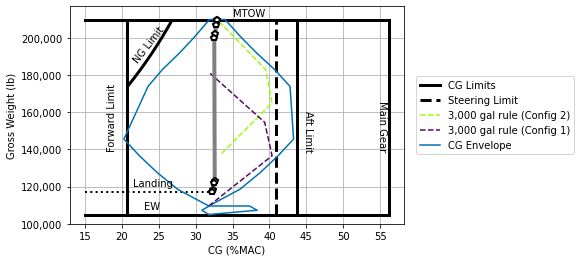

In [65]:
############LIMITS##########

xleft = 15
xright = 56

#MTOW
x = np.linspace(xleft, xright, 100)
y = MTOW + 0*x
plt.plot(x,y, linestyle='solid', linewidth = 3, color = 'black', label='CG Limits')

#Landing Weight
x = np.linspace(xleft, OnionRing(AfterDescent2, 0, 0)[0], 100)
y = Landing_Weight + 0*x
plt.plot(x,y, linestyle='dotted', linewidth = 2, color = 'black')

# #MZF
# x = np.linspace(xleft, xright, 100)
# y = MZF + 0*x
# plt.plot(x,y, linestyle = 'dashed')

#Empty_Weight
x = np.linspace(xleft, xright, 100)
y = EW + 0*x
plt.plot(x,y, linestyle='solid', linewidth = 3, color = 'black')

#Nose Landing Gear Max Weight Limit
x = np.linspace(Forward_Limit+0.1, 26.7, 1000)
inCG = (x/100)*MAC+LEMAC
y = NG_Weight_Limit*((inCG-NG_pos)/(MG_pos-inCG))+NG_Weight_Limit
plt.plot(x,y, linestyle='solid', linewidth = 3, color = 'black')

#Nose Landing Gear Steering Limit Fraction
x = np.linspace(EW, MTOW, 100)
NG_Steering = ptm(Steering_Limit) + 0*x
plt.plot(NG_Steering,x, linestyle='dashed', linewidth = 3, color = 'black', label='Steering Limit')

#Main Landing Gear Position
x = np.linspace(EW, MTOW, 100)
MainLandingGear = ptm(MG_pos) + 0*x
plt.plot(MainLandingGear, x, linestyle='solid', linewidth = 3, color = 'black')

#Forward Limit
x = np.linspace(EW, MTOW, 100)
Forward_Lim = Forward_Limit + 0*x
plt.plot(Forward_Lim,x, linestyle='solid', linewidth = 3, color = 'black')

#Aft Limit
x = np.linspace(EW, MTOW, 100)
Aft_Lim = Aft_Limit + 0*x
plt.plot(Aft_Lim,x, linestyle='solid', linewidth = 3, color = 'black')


##########CG Envelope##########

#Retardant Envelope
x = [OnionRing(0, 0, 0, 'pos')[2], OnionRing(0, 0, 1000, 'pos')[2], OnionRing(0, 0, 2000, 'pos')[2], OnionRing(0, 0, 3000, 'pos')[2], OnionRing(0, 0, 4000, 'pos')[2]]
y = [OnionRing(0, 0, 0)[1], OnionRing(0, 0, 1000)[1], OnionRing(0, 0, 2000)[1], OnionRing(0, 0, 3000)[1], OnionRing(0, 0, 4000)[1]]
# plt.plot(x, y)

a = [OnionRing(Fuel, 0, 4000, 'pos')[2], OnionRing(Fuel, 1000, 4000, 'pos')[2], OnionRing(Fuel, 2000, 4000, 'pos')[2], OnionRing(Fuel, 3000, 4000, 'pos')[2], OnionRing(Fuel, 4000, 4000, 'pos')[2]]
b = [OnionRing(Fuel, 0, 4000, 'pos')[1], OnionRing(Fuel, 1000, 4000, 'pos')[1], OnionRing(Fuel, 2000, 4000, 'pos')[1], OnionRing(Fuel, 3000, 4000, 'pos')[1], OnionRing(Fuel, 4000, 4000, 'pos')[1]]
# plt.plot(a, b)

c = [OnionRing(Fuel, 4000, 4000, 'neg')[2], OnionRing(Fuel, 4000, 3000, 'neg')[2], OnionRing(Fuel, 4000, 2000, 'neg')[2], OnionRing(Fuel, 4000, 1000, 'neg')[2], OnionRing(Fuel, 4000, 0, 'neg')[2]]
d = [OnionRing(Fuel, 4000, 4000, 'neg')[1], OnionRing(Fuel, 4000, 3000, 'neg')[1], OnionRing(Fuel, 4000, 2000, 'neg')[1], OnionRing(Fuel, 4000, 1000, 'neg')[1], OnionRing(Fuel, 4000, 0, 'neg')[1]]
# plt.plot(c, d)

e = [OnionRing(0, 4000, 0, 'neg')[2], OnionRing(0, 3000, 0, 'neg')[2], OnionRing(0, 2000, 0, 'neg')[2], OnionRing(0, 1000, 0, 'neg')[2], OnionRing(0, 0, 0, 'neg')[2]]
f = [OnionRing(0, 4000, 0, 'neg')[1], OnionRing(0, 3000, 0, 'neg')[1], OnionRing(0, 2000, 0, 'neg')[1], OnionRing(0, 1000, 0, 'neg')[1], OnionRing(0, 0, 0, 'neg')[1]]
# plt.plot(e, f)

x.extend(a)
x.extend(c)
x.extend(e)

y.extend(b)
y.extend(d)
y.extend(f)

plt.plot(x, y, color=(0/255, 114/255, 178/255))

# #Rule
# x = [OnionRing(Fuel, 0, 0)[0], OnionRing(Fuel, 2000, 0)[0], OnionRing(Fuel, 3000, 1000)[0], OnionRing(Fuel, 4000, 2000)[0], OnionRing(Fuel, 4000, 3000)[0], OnionRing(Fuel, 4000, 4000)[0]]
# y = [OnionRing(Fuel, 0, 0)[1], OnionRing(Fuel, 2000, 0)[1], OnionRing(Fuel, 3000, 1000)[1], OnionRing(Fuel, 4000, 2000)[1], OnionRing(Fuel, 4000, 3000)[1], OnionRing(Fuel, 4000, 4000)[1]]
# plt.plot(x,y, color='orange', linestyle='dashed', label='2000 gal rule')

# x = [OnionRing(0, 0, 0)[0], OnionRing(0, 2000, 0)[0], OnionRing(0, 3000, 1000)[0], OnionRing(0, 4000, 2000)[0], OnionRing(0, 4000, 3000)[0], OnionRing(0, 4000, 4000)[0]]
# y = [OnionRing(0, 0, 0)[1], OnionRing(0, 2000, 0)[1], OnionRing(0, 3000, 1000)[1], OnionRing(0, 4000, 2000)[1], OnionRing(0, 4000, 3000)[1], OnionRing(0, 4000, 4000)[1]]
# plt.plot(x,y, color='red', linestyle='dashed', label='2000 gal rule')

#Aft Rule
x = [OnionRing(Fuel, 0, 0)[0], OnionRing(Fuel, 0, 3000)[0], OnionRing(Fuel, 1000, 4000)[0], OnionRing(Fuel, 4000, 4000)[0]]
y = [OnionRing(Fuel, 0, 0)[1], OnionRing(Fuel, 0, 3000)[1], OnionRing(Fuel, 1000, 4000)[1], OnionRing(Fuel, 4000, 4000)[1]]
plt.plot(x,y, color=Config_2_Colour, linestyle='dashed', label='3,000 gal rule (Config 2)')

x = [OnionRing(0, 0, 0)[0], OnionRing(0, 0, 3000)[0], OnionRing(0, 1000, 4000)[0], OnionRing(0, 4000, 4000)[0]]
y = [OnionRing(0, 0, 0)[1], OnionRing(0, 0, 3000)[1], OnionRing(0, 1000, 4000)[1], OnionRing(0, 4000, 4000)[1]]
plt.plot(x,y, color=Config_1_Colour, linestyle='dashed', label='3,000 gal rule (Config 1)')

#Empty Tanks Envelope
x = [EmptyTanks(0, 0, 0)[0], EmptyTanks(0, 1600, 0)[0], EmptyTanks(0, Forward_Tank_pos, 1600)[0], EmptyTanks(0, Forward_Tank_pos, 1097.76)[0], EmptyTanks(0, Forward_Tank_pos, 0)[0], EmptyTanks(0, 0, 0)[0]]
y = [EmptyTanks(0, 0, 0)[1], EmptyTanks(0, 1600, 0)[1], EmptyTanks(0, Forward_Tank_pos, 1600)[1], EmptyTanks(0, Forward_Tank_pos, 1097.76)[1], EmptyTanks(0, Forward_Tank_pos, 0)[1], EmptyTanks(0, 0, 0)[1]]
plt.plot(x, y, color=(0/255, 114/255, 178/255), label='CG Envelope')

#Mission Path

#CG Path Both Tanks
x = [OnionRing(Fuel, 4000, 4000)[0], OnionRing(AfterTakeoff, 4000, 4000)[0], OnionRing(AfterClimb1, 4000, 4000)[0], OnionRing(AfterCruise1, 4000, 4000)[0], OnionRing(AfterDescent1, 4000, 4000)[0], OnionRing(AfterFirefighting, 0, 0)[0], OnionRing(AfterClimb2, 0, 0)[0], OnionRing(AfterCruise2, 0, 0)[0], OnionRing(AfterDescent2, 0, 0)[0]]
y = [OnionRing(Fuel, 4000, 4000)[1], OnionRing(AfterTakeoff, 4000, 4000)[1], OnionRing(AfterClimb1, 4000, 4000)[1], OnionRing(AfterCruise1, 4000, 4000)[1], OnionRing(AfterDescent1, 4000, 4000)[1], OnionRing(AfterFirefighting, 0, 0)[1], OnionRing(AfterClimb2, 0, 0)[1], OnionRing(AfterCruise2, 0, 0)[1], OnionRing(AfterDescent2, 0, 0)[1]]

plt.plot(x, y, '-p', color='gray',
         markersize=6, linewidth=4,
         markerfacecolor='white',
         markeredgecolor='black',
         markeredgewidth=2)

###############

plt.legend(bbox_to_anchor =(1.02, 0.5), loc = 'center left')
plt.text(35, MTOW+2000, 'MTOW', fontsize=10)
plt.text(21.5, EW+15000, 'Landing', fontsize=10)
# plt.text(15.5, MZF+3000, 'MZF', fontsize=10)
plt.text(18, 140000, 'Forward Limit', rotation = 90, fontsize=10)
plt.text(44.5, 140000, 'Aft Limit', rotation = 270, fontsize=10)
plt.text(23, EW+3000, 'EW', fontsize=10)
plt.text(21.3, 187000, 'NG Limit', rotation = 52, fontsize=10)
# plt.text(41, 186000, 'Steering', rotation = 270, fontsize=10)
plt.text(54.5, 140000, 'Main Gear', rotation = 270, fontsize=10)
plt.xlabel('CG (%MAC)')
plt.ylabel('Gross Weight (lb)')
plt.grid()
plt.xticks(np.arange(15, 55+1, 5.0))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylim(100000, 217000)
plt.show()
# plt.savefig('CG Envelope Overall', bbox_inches = 'tight', dpi=1200)


In [66]:
mtp(OnionRing(0, 0, 0)[0])

1007.7701151561391

In [67]:
OnionRing(0, 0, 4000)[0]-OnionRing(0, 4000, 0)[0]

21.450168324131408

In [220]:
OnionRing(0, 0, 4000)[1]

145594.64620000002